In [18]:
os.chdir(fml_path)

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import yfinance as yf

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR

from data import DataGJR, DataRes
from market_dynamics import bs_call_price
from models import ControlNet, EnsembleNet
from train import train_val
from risk_measures import median_loss
from utils import call_payoff, stochastic_integral

In [7]:
GJR_FOLDER = "v2/"
RES_FOLDER = "resssim/"

## Data

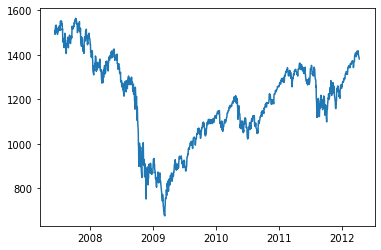

In [8]:
ticker = yf.Ticker('^GSPC')
hist = ticker.history(start='2007-06-11', end='2012-04-10').Close
plt.plot(hist);

In [9]:
# From fitting the GARCH model using R get following parameters

SIGMA = 0.1221684
MU = 0.056105

SQRT_252 = 252 ** 0.5

In [10]:
h_params = {"N_SIM": 4000,
            "RF": 0,
            "N_DIMS": 2,
            "FC_DIM": 20,
            "LR": 0.005,
            "GAMMA": 0.96,
            "EPOCHS": 10,
            "BATCH_SIZE": 256,}

In [11]:
initial_value = hist.iloc[0]
strike = initial_value
n_steps = 30
price = bs_call_price(n_steps, initial_value, SIGMA, h_params["RF"], strike)
initial_value, strike, SIGMA, price

(1509.1199951171875, 1509.1199951171875, 0.1221684, 21.0855397479188)

In [12]:
dt = DataGJR(GJR_FOLDER, price, call_payoff, {"strike": strike}, splits=h_params["N_SIM"], S0=initial_value, sigma_0=SIGMA, mu_const=MU, take_log=True, vol_feature=False)

## Training

In [13]:
%%time

# Training three models on different training paths

n_models = 3
models, optimizers, schedulers = [], [], []
n = 1000
val_n = 20
criterion = torch.nn.MSELoss()

for _ in range(n_models):
    model = ControlNet(n_steps, 1, [20, 20], 1, learn_price=False, learn_vol=False)
    models.append(model)
    optimizer = Adam(model.parameters(), lr=h_params["LR"])
    optimizers.append(optimizer)
    schedulers.append(ExponentialLR(optimizer, gamma=h_params["GAMMA"]))

idx_list = np.array_split(np.arange(n) + 1, 3)
val_idx_list = [np.arange(start=idx[-1]+1, stop=idx[-1]+1+val_n) for idx in idx_list]

# Training each model

res_list = []
for model, optimizer, scheduler, indices, val_indices in zip(models, optimizers, schedulers, idx_list, val_idx_list):
    results = train_val(dt, model, criterion, optimizer, h_params["EPOCHS"], indices, val_indices, scheduler, metric=median_loss, val_every=5)
    res_list.append(results)

ens = EnsembleNet(models)

Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [00:18<00:00, 17.88batch/s, loss=53.4, metric=21.1]


validation loss: 747.8818481445312


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [00:18<00:00, 17.78batch/s, loss=42, metric=17.7]


validation loss: 51.92439212799072


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 333/333 [00:18<00:00, 18.34batch/s, loss=54.4, metric=16.3]


validation loss: 2826.2915771484377


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 333/333 [00:18<00:00, 18.32batch/s, loss=45, metric=13.6]


validation loss: 2768.93984375


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 333/333 [00:18<00:00, 17.86batch/s, loss=37.9, metric=14.5]


validation loss: 4176.038110351563


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 333/333 [00:18<00:00, 17.86batch/s, loss=33, metric=14.6]


validation loss: 296.9997894287109


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 333/333 [00:18<00:00, 18.12batch/s, loss=31.8, metric=14.4]

CPU times: user 10min 42s, sys: 1min 53s, total: 12min 36s
Wall time: 9min 22s


## Performance on GJR validation paths & Delta Hedging Benchmark

In [14]:
# Cython code based on: https://github.com/JackJacquier/python-for-finance/blob/master/Session-7-Cython/Intro_to_Cython.ipynb

In [15]:
%load_ext Cython

In [16]:
%%cython --compile-args=-O3
cimport cython
from libc.math cimport  sqrt,log,exp,erf
cdef double ONE_OVER_SQRT_TWO=0.7071067811865476
import numpy as np
cimport numpy as cnp

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
cdef double gaussian_cdf(double x) nogil:
    return 0.5*(1+erf(x*ONE_OVER_SQRT_TWO))

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
cpdef cnp.ndarray[cnp.double_t, ndim=1] cython_bs_delta(cnp.ndarray[cnp.double_t, ndim=1] sigma, cnp.ndarray[cnp.double_t, ndim=1] S0,double K, cnp.ndarray[cnp.double_t, ndim=1] T):
    cdef int size=len(S0)
    cdef double k, d1, sigmaT
    cdef cnp.ndarray[cnp.double_t, ndim=1] result=np.zeros(size)
        
    with nogil:
        for i in range(size):
            sigmaT = sigma[i] * sqrt(T[i])
            k = log(S0[i] / K)
            d1 = k / sigmaT + 0.5*sigmaT
            result[i] = gaussian_cdf(d1)
        
    return result

In [17]:
# make index to pass decreasing time to maturity to the bs_delta function
idx = np.arange(n_steps) + 1
idx = idx[::-1]

In [18]:
def cython_d_hedge(x, vol):
    return cython_bs_delta(vol.numpy().astype(np.float64), torch.exp(x).numpy().astype(np.float64), strike, idx.astype(np.float64) *  ( 1 / 365))

def hedge_diff(x, x_inc, payoff, price, vol, model=ens, normalized=True, x1=None):

    # calculate delta hedge; assuming x is log price!
    if normalized:
        path = initial_value * x
    else:
        path = x
    
    d_hedge_list = [cython_d_hedge(a.squeeze(), b.squeeze()) for a, b in zip(path, vol)]
    si_delta = stochastic_integral(x_inc, torch.Tensor(d_hedge_list))
    diff_delta = (price.squeeze() + si_delta).float() - payoff.float()

    # calculating model hedge
    if dt.vol_feature:
        output = model(x, x1)
    else:
        output = model(x)

    if model.learn_price:
        output, price = output

    si = stochastic_integral(x_inc, output)
    diff = (price.squeeze() + si).float() - payoff.float()

    return diff, diff_delta

In [19]:
diffs, diffs_delta = [], []

for i in np.arange(start=3500, stop=3700):
    
    if dt.vol_feature:
        x, x1, x_inc, payoff, price = dt[i]
    else:
        x, x_inc, payoff, price = dt[i]
        x1 = None
        
    vol = dt.get_vol(i)
    diff, diff_delta = hedge_diff(x, x_inc, payoff, price, vol, x1=x1)
    diffs.append(diff)
    diffs_delta.append(diff_delta)
    
d = torch.cat(diffs)
d_delta = torch.cat(diffs_delta)

In [20]:
print('Model:')
print(f"RMSE {(d ** 2).mean() ** 0.5}")
print(f"Using median {(d ** 2).median() ** 0.5}")
print(f"Using mode {(d ** 2).mode()[0] ** 0.5}")

print('Delta Hedge:')
print(f"RMSE {(d_delta ** 2).mean() ** 0.5}")
print(f"Using median {(d_delta ** 2).median() ** 0.5}")
print(f"Using mode {(d_delta ** 2).mode()[0] ** 0.5}")

Model:
RMSE 6.723581314086914
Using median 3.3887939453125
Using mode 0.01953887939453125
Delta Hedge:
RMSE 15.667876243591309
Using median 9.739227294921875
Using mode 21.085538864135742


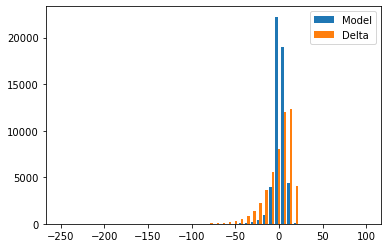

In [21]:
plt.hist([d.detach().numpy(), d_delta.detach().numpy()], range=(-250, 100), bins=50, label=['Model', 'Delta'])
plt.legend();

In [22]:
pd.Series(d_delta.detach()).describe()

count    51200.000000
mean        -0.094304
std         15.667855
min       -204.078278
25%         -7.247254
50%          3.881438
75%         10.595092
max         21.085539
dtype: float64

In [23]:
d_series = pd.Series(d.detach())
d_series.describe()

count    51200.000000
mean         1.216600
std          6.612624
min       -141.337021
25%         -1.430024
50%          1.509899
75%          4.880909
max         19.088650
dtype: float64

## Performance on real paths

In [24]:
# Creating the validation paths
n_steps = 30# Creating the validation paths

n_steps = 30
step = 5  # number of days by which to shift the window
sigma_est_period = 30
valid_paths, valid_prices, valid_strikes, sigma_estimates = [], [], [], []

for i in np.arange(start=sigma_est_period, stop=len(hist) - n_steps, step=step):
    
    valid_path = hist[i:i+n_steps+1]
    simga_est_path = hist[i-sigma_est_period:i]
    sigma_est = simga_est_path.diff().dropna().std() / 100
    sigma_estimates.append(sigma_est)

    S0 = valid_path[0]
    valid_price = bs_call_price(n_steps, S0, sigma=sigma_est, rf=0, strike=S0)      

    valid_paths.append(valid_path)
    valid_strikes.append(S0)
    valid_prices.append(valid_price)

valid_paths = np.array(valid_paths)
valid_paths = valid_paths.reshape(valid_paths.shape[0], valid_paths.shape[1], 1)
valid_paths = torch.from_numpy(valid_paths).float()

valid_prices = torch.Tensor(valid_prices)
valid_strikes = torch.Tensor(valid_strikes)

In [25]:
if dt.take_log:
    paths = valid_paths.squeeze().T /  valid_paths[:, 0].squeeze()
    paths = paths.T
    paths = torch.unsqueeze(paths, dim=2)
    paths = torch.log(paths[:, :-1])
    x_inc = valid_paths.squeeze().diff()

    payoff = call_payoff(valid_paths.squeeze(), strike=valid_strikes)

In [26]:
output = ens(paths)
si = stochastic_integral(x_inc, output)
diff = (valid_prices.squeeze() + si).float() - payoff.float()
d = diff

In [27]:
print('Model:')
print(f"RMSE {(d ** 2).mean() ** 0.5}")
print(f"Using median {(d ** 2).median() ** 0.5}")

Model:
RMSE 24.148603439331055
Using median 11.944046020507812


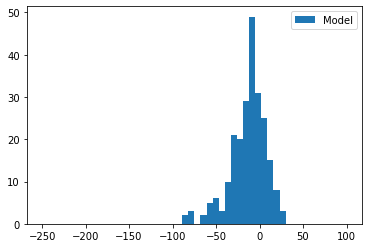

In [28]:
plt.hist(d.detach().numpy(), range=(-250, 100), bins=50, label=['Model'])
plt.legend();

In [29]:
d_series = pd.Series(d.detach())
d_series.describe()

count    232.000000
mean     -12.957440
std       20.421984
min      -88.134216
25%      -23.568654
50%       -9.252910
75%        0.251401
max       28.855267
dtype: float64

## Reservoir paths

In [30]:
res_dt = DataRes(RES_FOLDER, price, call_payoff, {"strike": strike}, splits=100, S0=initial_value, take_log=True)

In [31]:
diffs = []

for i in range(100):
    x, x_inc, payoff, price = res_dt[i]
    output = ens(x)
    si = stochastic_integral(x_inc, output)
    diff = (price.squeeze() + si).float() - payoff.float()
    diffs.append(diff)
    
d = torch.cat(diffs)

print('Model:')
print(f"RMSE {(d ** 2).mean() ** 0.5}")
print(f"Using median {(d ** 2).median() ** 0.5}")
print(f"Using mode {(d ** 2).mode()[0] ** 0.5}")

Model:
RMSE 15.091951370239258
Using median 10.518844604492188
Using mode 1.0627975463867188


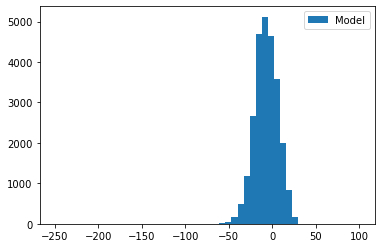

In [32]:
plt.hist(d.detach().numpy(), range=(-250, 100), bins=50, label=['Model'])
plt.legend();

## Compare with training on reservoir paths

In [46]:
%%time

# Training three models on different training paths

n_models = 3
models, optimizers, schedulers = [], [], []
n = 900
val_n = 20
criterion = torch.nn.MSELoss()

for _ in range(n_models):
    model = ControlNet(n_steps, 1, [20, 20], 1, learn_price=False, learn_vol=False)
    models.append(model)
    optimizer = Adam(model.parameters(), lr=h_params["LR"])
    optimizers.append(optimizer)
    schedulers.append(ExponentialLR(optimizer, gamma=h_params["GAMMA"]))

idx_list = np.array_split(np.arange(n) + 1, 3)
val_idx_list = [np.arange(start=idx[-1]+1, stop=idx[-1]+1+val_n) for idx in idx_list]

# Training each model

res_list = []
for model, optimizer, scheduler, indices, val_indices in zip(models, optimizers, schedulers, idx_list, val_idx_list):
    results = train_val(res_dt, model, criterion, optimizer, h_params["EPOCHS"], indices, val_indices, scheduler, metric=median_loss, val_every=5)
    res_list.append(results)

ens = EnsembleNet(models)

Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:12<00:00, 23.16batch/s, loss=89.5, metric=52.2]


validation loss: 21703.2056640625


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:12<00:00, 23.48batch/s, loss=83.2, metric=49.7]


validation loss: 5861.1658935546875


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:12<00:00, 23.44batch/s, loss=94.6, metric=53.3]


validation loss: 201319.64140625


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:12<00:00, 23.54batch/s, loss=84.1, metric=47.2]


validation loss: 39126.7607421875


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:12<00:00, 23.65batch/s, loss=91.7, metric=52.8]


validation loss: 18996.095458984375


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:12<00:00, 23.64batch/s, loss=75.3, metric=46.1]


validation loss: 1952.9287414550781


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:12<00:00, 23.63batch/s, loss=73.7, metric=45.6]

CPU times: user 7min 5s, sys: 41.5 s, total: 7min 46s
Wall time: 6min 24s


In [55]:
# Out of sample performance

diffs = []

for i in np.arange(n+10,1000):
    x, x_inc, payoff, price = res_dt[i]
    output = ens(x)
    si = stochastic_integral(x_inc, output)
    diff = (price.squeeze() + si).float() - payoff.float()
    diffs.append(diff)
    
d = torch.cat(diffs)

print('Model:')
print(f"RMSE {(d ** 2).mean() ** 0.5}")
print(f"Using median {(d ** 2).median() ** 0.5}")
print(f"Using mode {(d ** 2).mode()[0] ** 0.5}")

Model:
RMSE 8.993297576904297
Using median 7.256441116333008
Using mode 2.2422027587890625


In [56]:
diffs.append(diff)

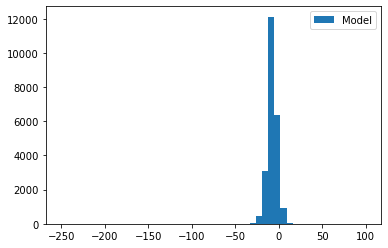

In [57]:
plt.hist(d.detach().numpy(), range=(-250, 100), bins=50, label=['Model'])
plt.legend();

In [58]:
# Performance on real data

if dt.take_log:
    paths = valid_paths.squeeze().T /  valid_paths[:, 0].squeeze()
    paths = paths.T
    paths = torch.unsqueeze(paths, dim=2)
    paths = torch.log(paths[:, :-1])
    x_inc = valid_paths.squeeze().diff()
    payoff = call_payoff(valid_paths.squeeze(), strike=valid_strikes)
    
    
output = ens(paths)
si = stochastic_integral(x_inc, output)
diff = (valid_prices.squeeze() + si).float() - payoff.float()
d = diff

print('Model:')
print(f"RMSE {(d ** 2).mean() ** 0.5}")
print(f"Using median {(d ** 2).median() ** 0.5}")
print(f"Using mode {(d ** 2).mode()[0] ** 0.5}")

Model:
RMSE 20.407093048095703
Using median 12.67622184753418
Using mode 0.14478302001953125


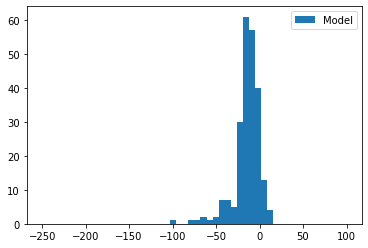

In [59]:
plt.hist(d.detach().numpy(), range=(-250, 100), bins=50, label=['Model'])
plt.legend();

### Plotting training, validation loss & metric

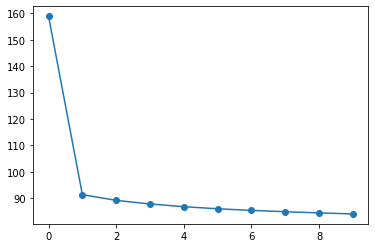

In [60]:
l, vl, m = res_list[1]
plt.plot(l, marker='o')

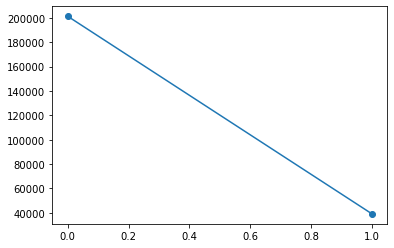

In [61]:
plt.plot(vl, marker='o')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


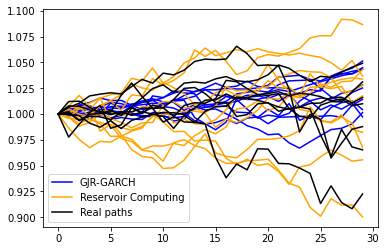

In [62]:
gjr_x, _, _, _, = dt[1]
res_x, _, _, _, = res_dt[1]
gjr_x, res_x = torch.exp(gjr_x), torch.exp(res_x)

gjr_example_paths = gjr_x[:10]
res_example_paths= res_x[:10]

fut = ticker.history(start='2018-01-02', end='2019-01-02').Close
m = np.floor(len(fut) / n_steps)
real_example_paths = []

for i in np.arange(start=0, stop=(m-1)*n_steps, step=n_steps):
    i = int(i)
    path = fut.iloc[i:i+n_steps].values
    path = path / path[0]
    real_example_paths.append(path)

plt.plot(gjr_example_paths.T.squeeze(), c='blue');
plt.plot(res_example_paths.T.squeeze(), c='orange');
plt.plot(np.array(real_example_paths).T, c='black');

# plt.legend(['GJR-GARCH', 'Reservoir Computing', 'Real paths'])
gjrpath_leg = Line2D([0], [0], color='blue', label='GJR-GARCH')
rc_leg = Line2D([0], [0], color='orange', label='Reservoir Computing')
real_leg = Line2D([0], [0], color='black', label='Real paths')
plt.legend(handles=[gjrpath_leg, rc_leg, real_leg])

plt.savefig('compare_paths.eps', format='eps')

plt.show()